In [ ]:
import sys
import os
from PIL import Image
import errno
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [ ]:


from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).



### Face recognition is an easy task for humans. So how hard could it be for a computer? Automatic face recognition is all about extracting those meaningful features from an image, putting them into a useful representation and performing some kind of classifcation on them.

The face images need to be stored in a folder hierachy similar to "image.png".


This function  can be used to read in the images for each subfolder of a given directory.

Each directory is given a unique (integer) label.
The function returns the images and the corresponding classes.

In [ ]:
#read images
def read_images (path , sz= None ):
    c = 0
    X,y = [], []
    for dirname , dirnames , filenames in os. walk ( path ):
        for subdirname in dirnames :
            subject_path = os. path . join ( dirname , subdirname )
            for filename in os. listdir ( subject_path ):
                try :
                    im = Image . open (os. path . join ( subject_path , filename ))
                    im = im. convert ("L")
                    # resize to given size (if given )
                    if (sz is not None ):
                        im = im. resize (sz , Image . LANCZOS )
                    X. append (np. asarray (im , dtype =np. uint8 ))
                    y. append (c)
                except IOError :
                    print ("I/O error ({0}) : {1} ". format (errno , os.strerror ))
                except :
                    print (" Unexpected error :", sys . exc_info () [0])
                    raise
            c = c+1
    return [X,y]

In [ ]:
def show_images(A, rows, cols, figsize = (10, 10)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        if i < len(A):
            ax.imshow(A[i], cmap='gray')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

The problem with the image representation we are given is its high dimensionality. Two-dimensional
p x q grayscale images span a m = pq-dimensional vector space, so an image with 100 x 100 pixels
lies in a 10000-dimensional image space already.

In [ ]:
def asRowMatrix(X):
    if len(X) == 0:
        return np.array([])
    mat = np.empty((0, X[0].size), dtype = X[0].dtype)
    for row in X:
        mat = np.vstack((mat, np.asarray(row).reshape(1, -1)))
    return mat

def asColumnMatrix(X):
    if len(X) == 0:
        return np.array([])
    mat = np.empty((X[0].size, 0), dtype = X[0].dtype)
    for col in X:
        mat = np.hstack((mat, np.asarray(col).reshape(-1, 1)))
    return mat

 That's way too much for any computations, but are
all dimensions really useful for us? We can only make a decision if there's any variance in data, so
what we are looking for are the components that account for most of the information.


The Principal
Component Analysis (PCA) was independently proposed by Karl Pearson (1901) and Harold Hotelling
(1933) to turn a set of possibly correlated variables into a smaller set of uncorrelated variables. The
idea is that a high-dimensional dataset is often described by correlated variables and therefore only a
few meaningful dimensions account for most of the information. The PCA method finds the directions
with the greatest variance in the data, called principal components.


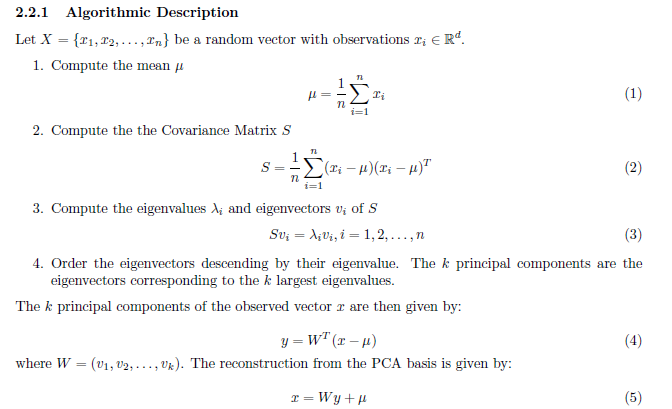

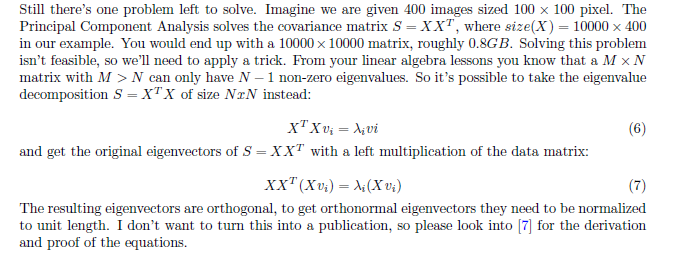

In [ ]:
def pca(X, y, num_components=0):
    [n, d] = X.shape
    if (num_components <= 0) or  (num_components > n):
        num_components = n
    mu = X.mean(axis = 0)
    X = X - mu
    if n>d:
        C = np.dot(X.T, X)
        [eigenvalues, eigenvectors] = np. linalg.eigh(C)
    else:
        C= np.dot(X, X.T)
        [eigenvalues, eigenvectors] = np.linalg.eigh(C)
        eigenvectors = np.dot(X.T, eigenvectors)
        for i in range(n):
            eigenvectors[:,i] = eigenvectors[:,i]/np.linalg.norm(eigenvectors[:,i])
    #sort eigenvalues
    idx = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]
    #select only num_components
    eigenvalues = eigenvalues[0:num_components].copy()
    eigenvectors = eigenvectors[:,0:num_components].copy()
    return [eigenvalues, eigenvectors, mu, X]

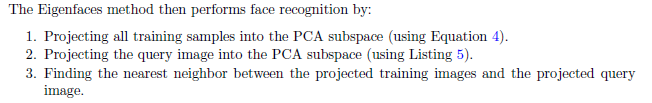

In [ ]:
def project(W, X, mu=None):
    if mu is None:
        return np.dot(X,W)
    return np.dot(X-mu, W)

def reconstruct(W, Y, mu=None):
    if mu is None:
        return np.dot(Y, W.T)
    return np.dot(Y, W.T) + mu

# The eigenvectors we have calculated can contain negative values, but the image data is excepted as unsigned integer values in the range of 0 to 255. So we need a function to normalize the data first

In [ ]:
def normalize (X, low , high , dtype = None ):
    X = np. asarray (X)
    minX , maxX = np. min (X), np. max (X)
    # normalize to [0...1].
    X = X - float ( minX )
    X = X / float (( maxX - minX ))
    # scale to [ low ... high ].
    X = X * (high - low )
    X = X + low
    if dtype is None :
        return np. asarray (X)
    return np. asarray (X, dtype = dtype )

In [ ]:
import matplotlib .cm as cm
def create_font ( fontname ='Tahoma', fontsize =10) :
    return { 'fontname': fontname , 'fontsize': fontsize }
def subplot (title , images , rows , cols , sptitle ="subplot", sptitles =[] , colormap =cm.gray , ticks_visible =True , filename = None ):
    fig = plt . figure ()
    # main title
    fig . text (.5 , .95 , title , horizontalalignment ='center')
    for i in range (len( images )):
        ax0 = fig . add_subplot (rows ,cols ,(i +1) )
        plt . setp ( ax0 . get_xticklabels () , visible = False )
        plt . setp ( ax0 . get_yticklabels () , visible = False )
        if len ( sptitles ) == len ( images ):
            plt . title ("%s #%s" % ( sptitle , str ( sptitles [i])), create_font ('Tahoma' ,10))
        else :
            plt . title ("%s #%d" % ( sptitle , (i +1)), create_font ('Tahoma' ,10))
        plt . imshow (np. asarray ( images [i]) , cmap = colormap )
    if filename is None :
        plt . show ()
    else :
        fig . savefig ( filename )

The code shown here loads images from a dataset, then displays them all together in a grid.

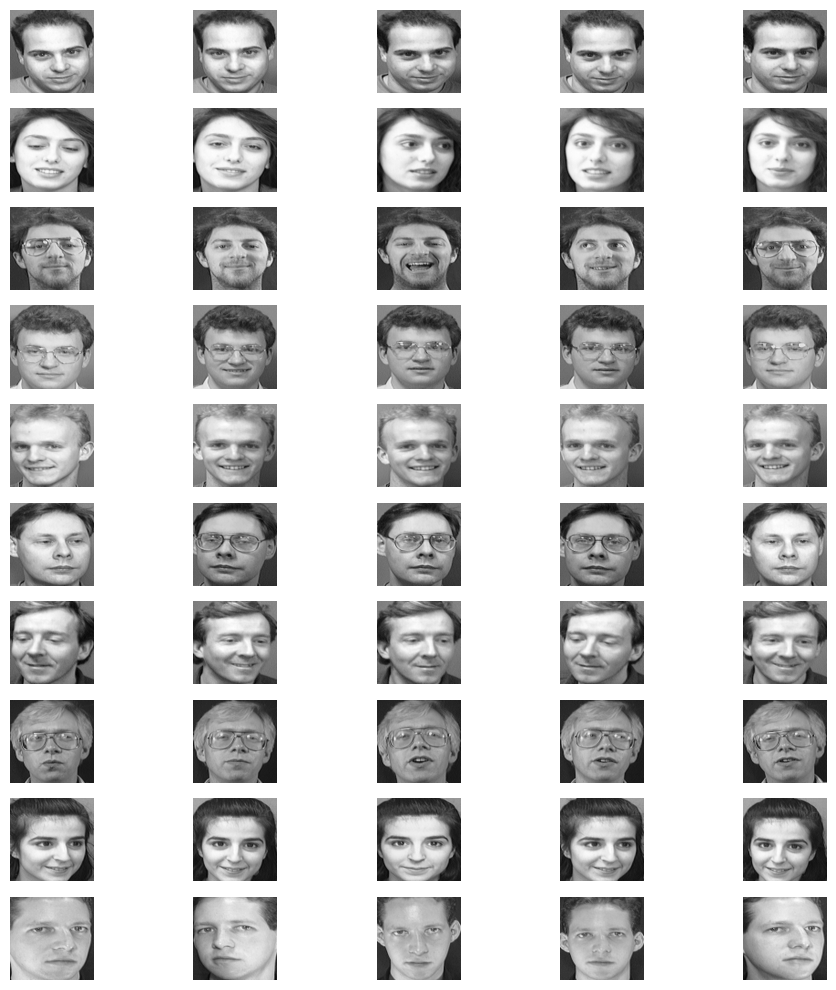

In [ ]:

[X, y] = read_images("/content/gdrive/MyDrive/Matematica Data Science/att_faces", sz=(512,512))
rows, cols = 10, 5  # Cambia questi valori per adattare la disposizione
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < len(X):  # Evita errori se ci sono meno immagini di quanto specificato in rows*cols
        ax.imshow(X[i], cmap='gray')
        ax.axis('off')  # Nasconde gli assi
plt.tight_layout()
plt.show()

### The code calculates and displays the "average face" of the dataset, which is useful in facial recognition to show what the average of all the faces in the dataset is, giving a general idea of ​​the dataset being used.

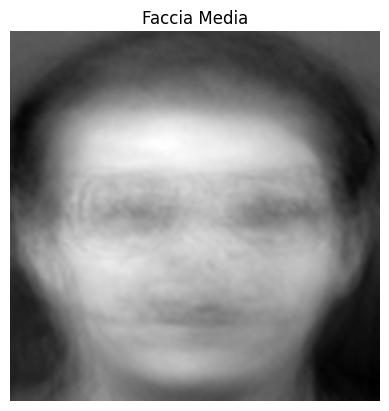

In [ ]:
[D, W, mu, X_centered] = pca(asRowMatrix(X), y)
  # Modifica in base alla dimensione effettiva delle immagini

# Reshape della media per trasformarla in una matrice 2D
mean_face = mu.reshape(X[0].shape)
plt.imshow(mean_face, cmap='gray')
plt.title("Faccia Media")
plt.axis('off')
plt.show()

### This code is used to display images after centering them on the mean (i.e. subtracting the mean from each image).

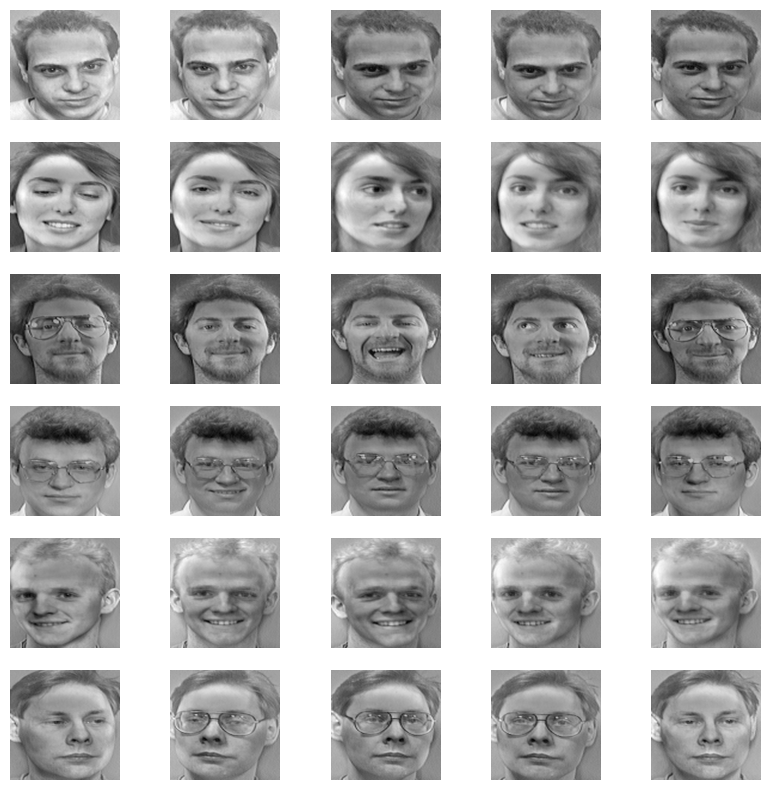

In [ ]:
rows, cols = 6, 5  # Cambia questi valori per adattare la disposizione
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = X_centered[i].reshape(X[0].shape)  # Trasforma l'immagine centrata in 2D
    ax.imshow(img, cmap='gray')  # Visualizza l'immagine in scala di grigi
    ax.axis('off')  # Nasconde gli assi
plt.show()

### This code is used to determine how many principal components need to be considered to explain a specific fraction (e.g. 95%) of the total variance in the data. In the context of PCA, this helps reduce the dimensionality of the data while still retaining most of the information (38)

In [ ]:
def num_comp(eigenvalues, epsilon):
    total_variance = sum(eigenvalues)
    c = 0
    k = 0
    while c / total_variance < epsilon:
        c += eigenvalues[k]
        k += 1
    return k


k = num_comp(D, 0.95)
print(k)

32


### The code is used to demonstrate how the number of principal components used for reconstruction affects image quality. By viewing images with an increasing number of principal components, you can see how the quality of the reconstruction improves as you include more components, as more information is captured.

### This representation is useful in face recognition to find a trade-off between dimensionality reduction (which reduces computational costs) and the quality of the image representation, which is essential for good recognition performance.

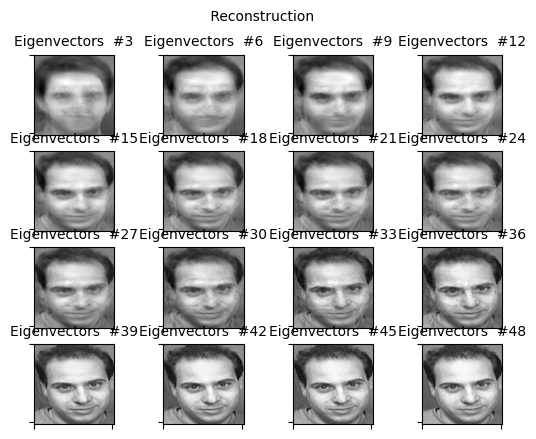

In [ ]:
# reconstruction steps
steps =[i for i in range (3 , min ( len (X), 320) , 3)]
E = []
for i in range ( min( len ( steps ), 16) ):
    numEvs = steps [i]
    P = project (W[: ,0: numEvs ], X [0]. reshape (1 , -1) , mu)
    R = reconstruct (W[: ,0: numEvs ], P, mu)
    # reshape and append to plots
    R = R. reshape (X [0]. shape )
    E. append ( normalize (R ,0 ,255) )
# plot them and store the plot to " python_reconstruction . pdf "
subplot ( title =" Reconstruction", images =E, rows =4, cols =4, sptitle ="Eigenvectors ", sptitles =steps , colormap =cm.gray , filename ="python_pca_reconstruction.png")

### The code is used to visualize the main "eigenfaces", which are a way to represent the direction of maximum variance in the face data. Eigenfaces represent the fundamental features that differentiate the faces in the dataset and are commonly used in PCA to reduce the dimensionality of the face recognition problem.

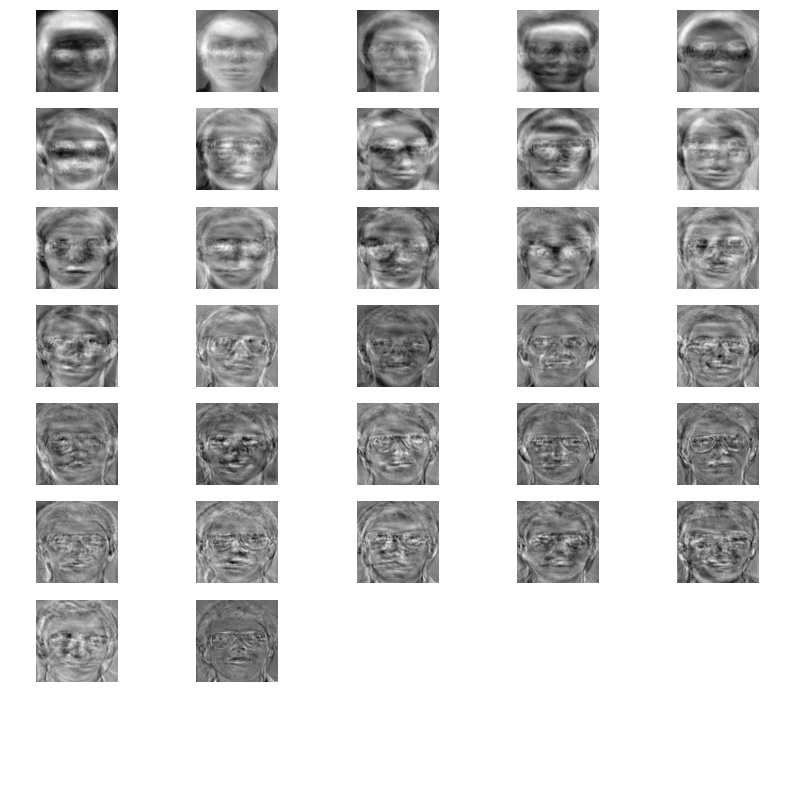

In [ ]:
rows = 8
cols = 5

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < k:
        eigenface = W[:, i].reshape(X[0].shape)  # Trasforma in 2D
        ax.imshow(eigenface, cmap='gray')
        ax.axis('off')  # Nasconde gli assi
    else:
        ax.axis('off')  # Nasconde qualsiasi asse in più, se presente


plt.show()

In [ ]:
[D, W, mu, X_centered] = pca (asRowMatrix(X), y, num_components = k)

# the projection of the centered data into the principal component space

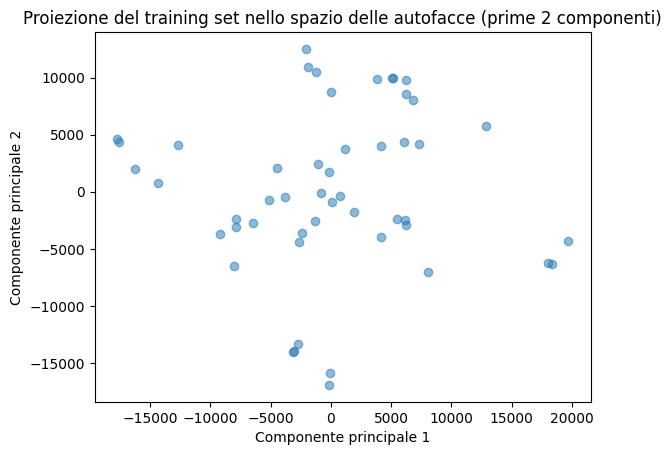

In [ ]:
X_projected = project(W, X_centered)
plt.scatter(X_projected[:, 0], X_projected[:, 1], alpha=0.5)
plt.title("Proiezione del training set nello spazio delle autofacce (prime 2 componenti)")
plt.xlabel("Componente principale 1")
plt.ylabel("Componente principale 2")
plt.show()

### The code displays a comparison between original images and their reconstructed versions after applying PCA, thus demonstrating the effectiveness of principal component reconstruction.

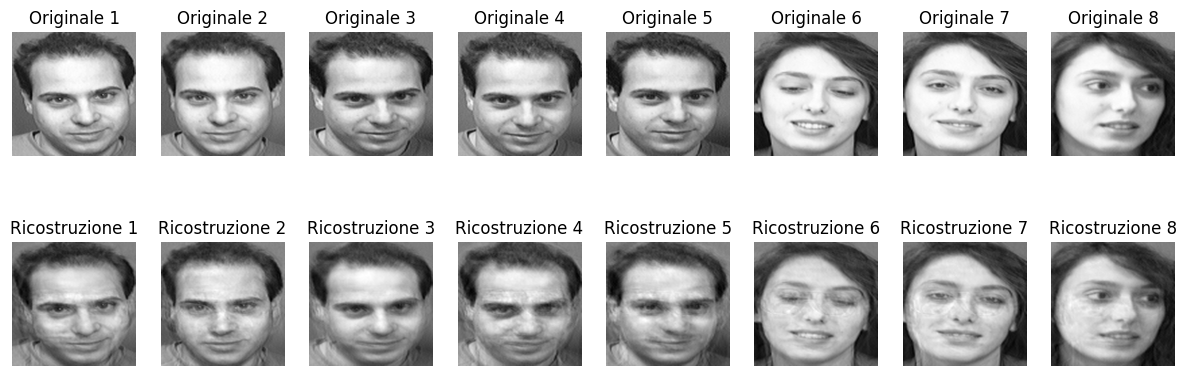

In [ ]:
P = project (W, X_centered)
R = reconstruct (W, P, mu)
#R = reconstruct (W[: ,0: numEvs ], P, mu)
num_images_to_plot = 16  # Numero di immagini da visualizzare
  # Dimensioni delle immagini originali, modifica in base al tuo dataset

fig, axes = plt.subplots(2, num_images_to_plot // 2, figsize=(15, 5))
for i in range(num_images_to_plot // 2):
    # Immagine originale
    ax = axes[0, i]
    ax.imshow(X[i].reshape(X[0].shape), cmap='gray')
    ax.set_title(f"Originale {i+1}")
    ax.axis('off')

    # Immagine ricostruita
    ax = axes[1, i]
    ax.imshow(R[i].reshape(X[0].shape), cmap='gray')
    ax.set_title(f"Ricostruzione {i+1}")
    ax.axis('off')


plt.show()

## Import 3 different datasets to verify that the "model" can actually recognize the faces belonging to the original dataset

In [ ]:
[T1, t1] = read_images("/content/gdrive/MyDrive/Matematica Data Science/T1.1", sz = X[0].shape)
[T2, t2]= read_images("/content/gdrive/MyDrive/Matematica Data Science/T2", sz = X[0].shape)
[T3, t3]= read_images("/content/gdrive/MyDrive/Matematica Data Science/T3", sz = X[0].shape)

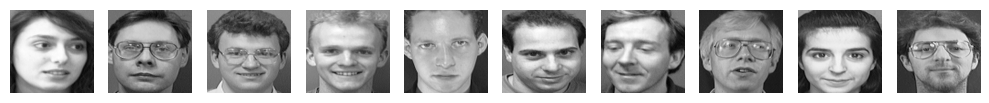

In [ ]:
show_images(T1, 1,10)

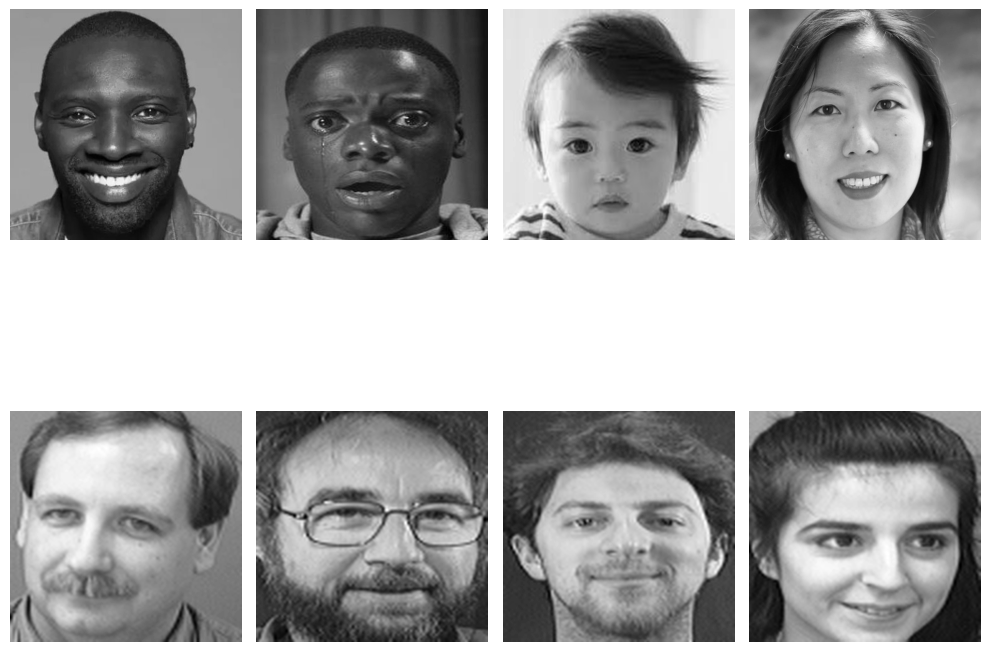

In [ ]:
show_images(T2, 2, 4)

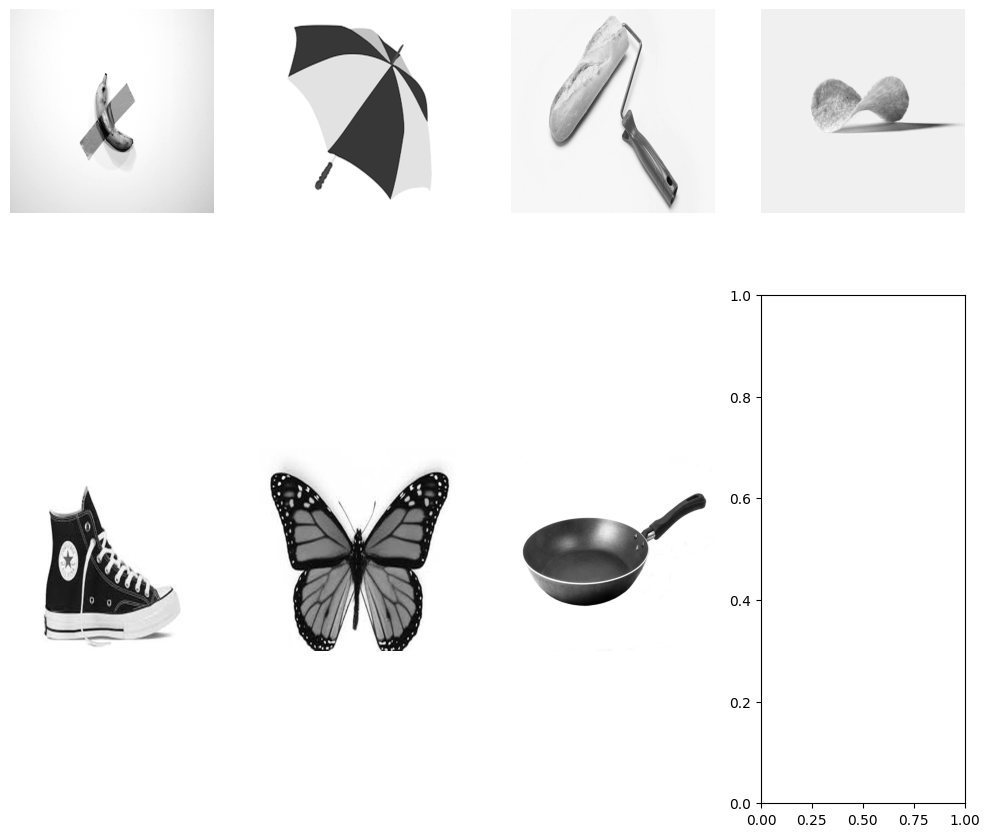

In [ ]:
show_images(T3, 2, 4)

# project the 3 datasets into the principal component space

In [ ]:
P = project(W, asRowMatrix(X), mu)
T1_projections = project(W, asRowMatrix(T1), mu)
T2_projections = project(W, asRowMatrix(T2), mu)
T3_projections = project(W, asRowMatrix(T3), mu)

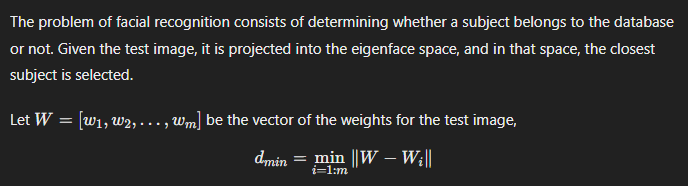

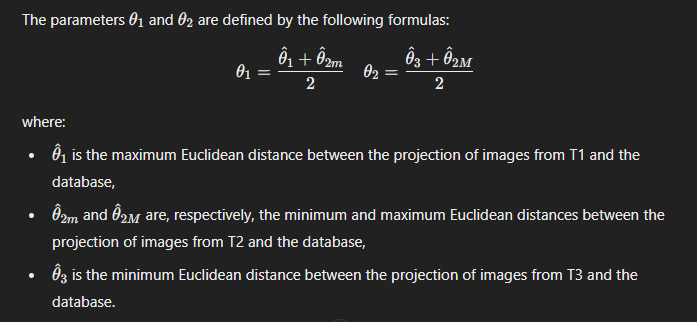

In [ ]:
from scipy.spatial.distance import cdist

# Calcola la matrice delle distanze euclidee tra le proiezioni di T1 e le proiezioni del database
distances_T1 = cdist(T1_projections, P, metric='euclidean')


# \theta_1 è il massimo di tutte queste distanze
theta1 = np.max(distances_T1)
print(f"θ1 (massima distanza tra T1 e il database): {theta1}")

θ1 (massima distanza tra T1 e il database): 39441.875675510906


In [ ]:
distances_T2 = cdist(T2_projections, P, metric='euclidean')

# \theta_{2m} è la minima distanza e \theta_{2M} è la massima distanza
theta2m = np.min(distances_T2)
theta2M = np.max(distances_T2)
print(f"θ2m (minima distanza tra T2 e il database): {theta2m}")
print(f"θ2M (massima distanza tra T2 e il database): {theta2M}")

θ2m (minima distanza tra T2 e il database): 0.0
θ2M (massima distanza tra T2 e il database): 52265.29182865031


In [ ]:
distances_T3 = cdist(T3_projections, P, metric='euclidean')

# \theta_3 è la minima distanza tra le proiezioni di T3 e il database
theta3 = np.min(distances_T3)
print(f"θ3 (minima distanza tra T3 e il database): {theta3}")

θ3 (minima distanza tra T3 e il database): 37321.394587606825


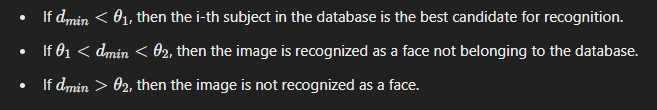

In [ ]:
Theta1 =( (theta1 + theta2m)/2)
Theta2 = ((theta3 + theta2M)/2)
print(f"{Theta1}<soglia<{Theta2}")

19720.937837755453<soglia<44793.34320812857


In [ ]:
from scipy.spatial.distance import cdist

def classify_images(test_images, eigenvectors, mu, database_projections, t1, t2):
    """
    Classifica ciascuna immagine in base alla sua proiezione nello spazio delle autofacce
    e determina se appartiene al database, è sconosciuta o non è una faccia.

    Parameters:
    - test_images: Lista di immagini di test (in formato flatten e centrate).
    - eigenvectors: Matrice di autovettori (autofacce).
    - mu: Vettore della media delle immagini.
    - database_projections: Proiezioni delle immagini del database nello spazio delle autofacce.
    - t1: Soglia inferiore.
    - t2: Soglia superiore.

    Returns:
    - risultati: Lista di stringhe che indicano la classificazione per ciascuna immagine di test.
    """
    risultati = []
    for test_image in test_images:
        # Proietta l'immagine di test nello spazio delle autofacce
        test_image_centered = test_image - mu # Centra l'immagine
        W = np.dot(test_image_centered, eigenvectors)  # Vettore dei pesi della proiezione

        # Calcola la distanza minima dal database
        #distances = cdist(database_projections, W.reshape(1,-1), metric='euclidean')
        distances = np.linalg.norm(database_projections - W, axis=1)
        d_min = np.min(distances)
        # Classificazione basata sulle soglie
        print(d_min)
        if d_min <= t1:
            risultati.append("Appartiene al database (faccia nota)")
        elif t1 < d_min <= t2:
            risultati.append("Faccia sconosciuta (non nel database)")
        elif d_min > t2:
            risultati.append("Non è una faccia o non appartiene al contesto")

    return risultati

In [ ]:
risultati = classify_images(asRowMatrix(T1), W, mu, P, Theta1, Theta2)

# Stampa i risultati
for idx, risultato in enumerate(risultati):
    print(f"Immagine {idx + 1}: {risultato}")

1.2151231791188209e-10
7.79733483487209e-11
1.0601813388511459e-10
1.456633376804403e-10
1.2636592099344055e-10
9.409604319083941e-11
1.606870089212239e-10
9.915575334691719e-11
2.2145349022268638e-10
1.1275102161899622e-10
Immagine 1: Appartiene al database (faccia nota)
Immagine 2: Appartiene al database (faccia nota)
Immagine 3: Appartiene al database (faccia nota)
Immagine 4: Appartiene al database (faccia nota)
Immagine 5: Appartiene al database (faccia nota)
Immagine 6: Appartiene al database (faccia nota)
Immagine 7: Appartiene al database (faccia nota)
Immagine 8: Appartiene al database (faccia nota)
Immagine 9: Appartiene al database (faccia nota)
Immagine 10: Appartiene al database (faccia nota)


In [ ]:
risultati = classify_images(asRowMatrix(T2), W, mu, P, Theta1, Theta2)

# Stampa i risultati
for idx, risultato in enumerate(risultati):
    print(f"Immagine {idx + 1}: {risultato}")

#6

27314.218245740303
25448.33141054672
29604.288123300143
20417.62967516531
11413.589510556598
15667.936668554597
1.293133066135315e-10
7.51305542045914e-11
Immagine 1: Faccia sconosciuta (non nel database)
Immagine 2: Faccia sconosciuta (non nel database)
Immagine 3: Faccia sconosciuta (non nel database)
Immagine 4: Faccia sconosciuta (non nel database)
Immagine 5: Appartiene al database (faccia nota)
Immagine 6: Appartiene al database (faccia nota)
Immagine 7: Appartiene al database (faccia nota)
Immagine 8: Appartiene al database (faccia nota)


In [ ]:
risultati = classify_images(asRowMatrix(T3), W, mu, P, Theta1, Theta2)

# Stampa i risultati
for idx, risultato in enumerate(risultati):
    print(f"Immagine {idx + 1}: {risultato}")

#18

43433.293650286105
41083.33013844087
42661.64138442596
44220.96759341479
44672.52045561707
37321.39458760692
45200.62167165265
Immagine 1: Faccia sconosciuta (non nel database)
Immagine 2: Faccia sconosciuta (non nel database)
Immagine 3: Faccia sconosciuta (non nel database)
Immagine 4: Faccia sconosciuta (non nel database)
Immagine 5: Faccia sconosciuta (non nel database)
Immagine 6: Faccia sconosciuta (non nel database)
Immagine 7: Non è una faccia o non appartiene al contesto
